In [1]:
import keras
import os
os.environ['KERAS_BACKEND']='tensorflow'
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1337)  # for reproducibility

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.callbacks import TensorBoard

def setGPU():   
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.3
    set_session(tf.Session(config=config))
#setGPU()

print('libs loaded')

/home/ian/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


libs loaded


In [2]:
# perameters

size = 256

(341, 256, 256, 1)
(341, 256, 256, 1)


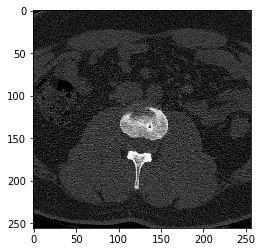

In [3]:
def load_data():
    filenames = []
    for root, dirs, files in os.walk('./data/x'):
        for name in files:
            filenames.append(os.path.join(root, name).split('/')[-1])

    num = len(filenames)
    size = 256
    data_shape = (num, size, size)
    X = np.zeros(data_shape)
    Y = np.zeros(data_shape)
    
    for i in range(num):
        f = filenames[i]
        img = np.array(cv2.imread('./data/x/' + f, 0))
        img2 = np.array(cv2.imread('./data/y/' + f, 0))
        X[i, :, :] = img
        Y[i, :, :] = img2
    
    X = X.reshape(num, size, size, 1)
    Y = Y.reshape(num, size, size, 1)
    
    X = X.astype('float32')
    Y = Y.astype('float32')
    
    X /= 255
    Y /= 255
    
    print(X.shape)
    
    return X, Y

X_train, Y_train = load_data()
print(X_train.shape)
plt.imshow(X_train[0,:,:,0], cmap='gray')



In [4]:
import random
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Multiply(),
    iaa.GaussianBlur(sigma=(0, 3.0)),
    iaa.ContrastNormalization(),
    iaa.MedianBlur(),
    #iaa.Add(),
    #iaa.AverageBlur(),
    #iaa.MedianBlur(),
    #iaa.Dropout(),
    #iaa.Salt(),
    #iaa.Pepper()
    
])

def batch():
    size = 256
    num_of_output = 10
    num_of_img = X_train.shape[0]
    
    random_list = random.sample(range(num_of_img), num_of_output)
    #print(random_list)
    
    data_shape = (num_of_output, size, size, 1)
    X = np.zeros(data_shape)
    Y = np.zeros(data_shape)
    
    for i in range(num_of_output):
        X[i] = X_train[random_list[i]]
        Y[i] = Y_train[random_list[i]]
        
    X = seq.augment_images(X)
        
    return X, Y
#batch(X_train, Y_train)
    

In [5]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

model = unet()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

/home/ian/.local/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ian/.local/lib/python3.5/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ian/.local/lib/python3.5/site-packages/ipykernel_launcher.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ian/.local/lib/python3.5/site-packages/ipykernel_launcher.py:32: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ian/.local/lib/python3.5/site-packages/ipykernel_launc

In [6]:

# training
nb_epoch = 10000
for e in range(nb_epoch):
    print("epoch %d" % e)
    X_batch, Y_batch = batch()
    model.fit(X_batch, Y_batch)

epoch 0
Epoch 1/1
10/10 [==============================] - 7s 678ms/step - loss: 0.7025 - acc: 0.1146
epoch 1
Epoch 1/1
10/10 [==============================] - 0s 47ms/step - loss: 0.6841 - acc: 0.8465
epoch 2
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.6618 - acc: 0.8978
epoch 3
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.5971 - acc: 0.8940
epoch 4
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.4475 - acc: 0.9044
epoch 5
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.6242 - acc: 0.9060
epoch 6
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.4437 - acc: 0.9110
epoch 7
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.4639 - acc: 0.8903
epoch 8
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.4890 - acc: 0.9173
epoch 9
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.5102 - a

epoch 81
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0714 - acc: 0.9161
epoch 82
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0538 - acc: 0.9371
epoch 83
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0571 - acc: 0.9304
epoch 84
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0640 - acc: 0.9201
epoch 85
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0640 - acc: 0.9190
epoch 86
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0770 - acc: 0.9061
epoch 87
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0667 - acc: 0.9185
epoch 88
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0577 - acc: 0.9299
epoch 89
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0756 - acc: 0.9053
epoch 90
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0

epoch 161
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0493 - acc: 0.9241
epoch 162
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0599 - acc: 0.9080
epoch 163
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0575 - acc: 0.9112
epoch 164
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0744 - acc: 0.8879
epoch 165
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0543 - acc: 0.9184
epoch 166
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0609 - acc: 0.9072
epoch 167
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0818 - acc: 0.8791
epoch 168
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0620 - acc: 0.9049
epoch 169
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0726 - acc: 0.8909
epoch 170
Epoch 1/1
10/10 [==============================] - 0s 43ms/step

epoch 241
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0551 - acc: 0.9246
epoch 242
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0603 - acc: 0.9174
epoch 243
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0473 - acc: 0.9351
epoch 244
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0683 - acc: 0.9021
epoch 245
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0485 - acc: 0.9302
epoch 246
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0636 - acc: 0.9093
epoch 247
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0514 - acc: 0.9276
epoch 248
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0558 - acc: 0.9183
epoch 249
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0556 - acc: 0.9182
epoch 250
Epoch 1/1
10/10 [==============================] - 0s 43ms/step

epoch 321
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0291 - acc: 0.9499
epoch 322
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0209 - acc: 0.9625
epoch 323
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0190 - acc: 0.9653
epoch 324
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0251 - acc: 0.9575
epoch 325
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0272 - acc: 0.9502
epoch 326
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0253 - acc: 0.9549
epoch 327
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0219 - acc: 0.9631
epoch 328
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0271 - acc: 0.9531
epoch 329
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0289 - acc: 0.9511
epoch 330
Epoch 1/1
10/10 [==============================] - 0s 43ms/step

epoch 401
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0263 - acc: 0.9482
epoch 402
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0230 - acc: 0.9559
epoch 403
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0200 - acc: 0.9603
epoch 404
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0216 - acc: 0.9541
epoch 405
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0265 - acc: 0.9461
epoch 406
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0231 - acc: 0.9524
epoch 407
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0149 - acc: 0.9642
epoch 408
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0115 - acc: 0.9722
epoch 409
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0207 - acc: 0.9607
epoch 410
Epoch 1/1
10/10 [==============================] - 0s 43ms/step

epoch 481
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0211 - acc: 0.9511
epoch 482
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0207 - acc: 0.9496
epoch 483
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0197 - acc: 0.9549
epoch 484
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0222 - acc: 0.9487
epoch 485
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0194 - acc: 0.9518
epoch 486
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0124 - acc: 0.9626
epoch 487
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0265 - acc: 0.9441
epoch 488
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0197 - acc: 0.9516
epoch 489
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0208 - acc: 0.9499
epoch 490
Epoch 1/1
10/10 [==============================] - 0s 43ms/step

epoch 561
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0130 - acc: 0.9634
epoch 562
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0148 - acc: 0.9592
epoch 563
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0186 - acc: 0.9550
epoch 564
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0157 - acc: 0.9573
epoch 565
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0225 - acc: 0.9461
epoch 566
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0147 - acc: 0.9631
epoch 567
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0117 - acc: 0.9671
epoch 568
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0151 - acc: 0.9606
epoch 569
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0169 - acc: 0.9544
epoch 570
Epoch 1/1
10/10 [==============================] - 0s 43ms/step

epoch 641
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0125 - acc: 0.9621
epoch 642
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0175 - acc: 0.9540
epoch 643
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0207 - acc: 0.9525
epoch 644
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0158 - acc: 0.9559
epoch 645
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0134 - acc: 0.9603
epoch 646
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0182 - acc: 0.9514
epoch 647
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0120 - acc: 0.9644
epoch 648
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0178 - acc: 0.9500
epoch 649
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0157 - acc: 0.9547
epoch 650
Epoch 1/1
10/10 [==============================] - 0s 44ms/step

epoch 721
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0115 - acc: 0.9650
epoch 722
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0134 - acc: 0.9610
epoch 723
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0160 - acc: 0.9582
epoch 724
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0176 - acc: 0.9495
epoch 725
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0173 - acc: 0.9506
epoch 726
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0111 - acc: 0.9624
epoch 727
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0151 - acc: 0.9525
epoch 728
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0148 - acc: 0.9584
epoch 729
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0138 - acc: 0.9569
epoch 730
Epoch 1/1
10/10 [==============================] - 0s 43ms/step

epoch 801
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0122 - acc: 0.9630
epoch 802
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0118 - acc: 0.9610
epoch 803
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0230 - acc: 0.9374
epoch 804
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0165 - acc: 0.9550
epoch 805
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0156 - acc: 0.9528
epoch 806
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0154 - acc: 0.9559
epoch 807
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0174 - acc: 0.9514
epoch 808
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0104 - acc: 0.9682
epoch 809
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0114 - acc: 0.9648
epoch 810
Epoch 1/1
10/10 [==============================] - 0s 44ms/step

epoch 881
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0143 - acc: 0.9534
epoch 882
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0117 - acc: 0.9606
epoch 883
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0178 - acc: 0.9481
epoch 884
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0140 - acc: 0.9549
epoch 885
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0163 - acc: 0.9511
epoch 886
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0176 - acc: 0.9496
epoch 887
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0175 - acc: 0.9533
epoch 888
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0132 - acc: 0.9610
epoch 889
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0158 - acc: 0.9527
epoch 890
Epoch 1/1
10/10 [==============================] - 0s 43ms/step

epoch 961
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0189 - acc: 0.9443
epoch 962
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0156 - acc: 0.9550
epoch 963
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0108 - acc: 0.9640
epoch 964
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0106 - acc: 0.9655
epoch 965
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0138 - acc: 0.9544
epoch 966
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0119 - acc: 0.9620
epoch 967
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0107 - acc: 0.9635
epoch 968
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0156 - acc: 0.9513
epoch 969
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0082 - acc: 0.9715
epoch 970
Epoch 1/1
10/10 [==============================] - 0s 44ms/step

10/10 [==============================] - 0s 44ms/step - loss: 0.0162 - acc: 0.9467
epoch 1041
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0143 - acc: 0.9570
epoch 1042
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0089 - acc: 0.9661
epoch 1043
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0139 - acc: 0.9526
epoch 1044
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0130 - acc: 0.9576
epoch 1045
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0151 - acc: 0.9485
epoch 1046
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0144 - acc: 0.9509
epoch 1047
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0155 - acc: 0.9576
epoch 1048
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0138 - acc: 0.9538
epoch 1049
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.

epoch 1119
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0078 - acc: 0.9733
epoch 1120
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0199 - acc: 0.9470
epoch 1121
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0146 - acc: 0.9559
epoch 1122
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0141 - acc: 0.9579
epoch 1123
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0132 - acc: 0.9554
epoch 1124
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0129 - acc: 0.9605
epoch 1125
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0117 - acc: 0.9573
epoch 1126
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0126 - acc: 0.9578
epoch 1127
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0081 - acc: 0.9679
epoch 1128
Epoch 1/1
10/10 [==============================] - 0s

epoch 1198
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0185 - acc: 0.9439
epoch 1199
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0180 - acc: 0.9462
epoch 1200
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0151 - acc: 0.9526
epoch 1201
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0115 - acc: 0.9611
epoch 1202
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0141 - acc: 0.9561
epoch 1203
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0121 - acc: 0.9588
epoch 1204
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0153 - acc: 0.9491
epoch 1205
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0130 - acc: 0.9560
epoch 1206
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0101 - acc: 0.9671
epoch 1207
Epoch 1/1
10/10 [==============================] - 0s

epoch 1277
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0132 - acc: 0.9567
epoch 1278
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0113 - acc: 0.9613
epoch 1279
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0122 - acc: 0.9582
epoch 1280
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0122 - acc: 0.9601
epoch 1281
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0126 - acc: 0.9570
epoch 1282
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0085 - acc: 0.9692
epoch 1283
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0123 - acc: 0.9558
epoch 1284
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0124 - acc: 0.9579
epoch 1285
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0097 - acc: 0.9648
epoch 1286
Epoch 1/1
10/10 [==============================] - 0s

epoch 1356
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0115 - acc: 0.9651
epoch 1357
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0153 - acc: 0.9526
epoch 1358
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0119 - acc: 0.9550
epoch 1359
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0106 - acc: 0.9616
epoch 1360
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0097 - acc: 0.9640
epoch 1361
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0128 - acc: 0.9601
epoch 1362
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0141 - acc: 0.9584
epoch 1363
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0123 - acc: 0.9604
epoch 1364
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0123 - acc: 0.9526
epoch 1365
Epoch 1/1
10/10 [==============================] - 0s

epoch 1435
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0162 - acc: 0.9451
epoch 1436
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0128 - acc: 0.9565
epoch 1437
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0159 - acc: 0.9467
epoch 1438
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0131 - acc: 0.9569
epoch 1439
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0133 - acc: 0.9538
epoch 1440
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0100 - acc: 0.9585
epoch 1441
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0107 - acc: 0.9582
epoch 1442
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0106 - acc: 0.9637
epoch 1443
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0112 - acc: 0.9634
epoch 1444
Epoch 1/1
10/10 [==============================] - 0s

epoch 1514
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0148 - acc: 0.9492
epoch 1515
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0095 - acc: 0.9646
epoch 1516
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0110 - acc: 0.9562
epoch 1517
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0142 - acc: 0.9506
epoch 1518
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0132 - acc: 0.9605
epoch 1519
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0135 - acc: 0.9535
epoch 1520
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0133 - acc: 0.9526
epoch 1521
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0152 - acc: 0.9481
epoch 1522
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0130 - acc: 0.9551
epoch 1523
Epoch 1/1
10/10 [==============================] - 0s

epoch 1593
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0115 - acc: 0.9568
epoch 1594
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0113 - acc: 0.9634
epoch 1595
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0121 - acc: 0.9594
epoch 1596
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0131 - acc: 0.9517
epoch 1597
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0120 - acc: 0.9534
epoch 1598
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0142 - acc: 0.9522
epoch 1599
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0207 - acc: 0.9392
epoch 1600
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0107 - acc: 0.9616
epoch 1601
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0117 - acc: 0.9562
epoch 1602
Epoch 1/1
10/10 [==============================] - 0s

epoch 1672
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0135 - acc: 0.9504
epoch 1673
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0109 - acc: 0.9605
epoch 1674
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0099 - acc: 0.9591
epoch 1675
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0091 - acc: 0.9637
epoch 1676
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0165 - acc: 0.9520
epoch 1677
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0096 - acc: 0.9659
epoch 1678
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0111 - acc: 0.9614
epoch 1679
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0107 - acc: 0.9597
epoch 1680
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0133 - acc: 0.9563
epoch 1681
Epoch 1/1
10/10 [==============================] - 0s

epoch 1751
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0125 - acc: 0.9532
epoch 1752
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0099 - acc: 0.9613
epoch 1753
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0135 - acc: 0.9566
epoch 1754
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0102 - acc: 0.9602
epoch 1755
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0099 - acc: 0.9634
epoch 1756
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0102 - acc: 0.9573
epoch 1757
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0122 - acc: 0.9550
epoch 1758
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0137 - acc: 0.9508
epoch 1759
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0080 - acc: 0.9665
epoch 1760
Epoch 1/1
10/10 [==============================] - 0s

epoch 1830
Epoch 1/1
10/10 [==============================] - 0s 46ms/step - loss: 0.0157 - acc: 0.9500
epoch 1831
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0085 - acc: 0.9684
epoch 1832
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0105 - acc: 0.9607
epoch 1833
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0083 - acc: 0.9662
epoch 1834
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0101 - acc: 0.9590
epoch 1835
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0104 - acc: 0.9600
epoch 1836
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0138 - acc: 0.9559
epoch 1837
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0143 - acc: 0.9577
epoch 1838
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0126 - acc: 0.9574
epoch 1839
Epoch 1/1
10/10 [==============================] - 0s

epoch 1909
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0100 - acc: 0.9628
epoch 1910
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0164 - acc: 0.9450
epoch 1911
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0136 - acc: 0.9521
epoch 1912
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0111 - acc: 0.9602
epoch 1913
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0077 - acc: 0.9658
epoch 1914
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0109 - acc: 0.9528
epoch 1915
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0105 - acc: 0.9551
epoch 1916
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0066 - acc: 0.9719
epoch 1917
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0102 - acc: 0.9607
epoch 1918
Epoch 1/1
10/10 [==============================] - 0s

epoch 1988
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0157 - acc: 0.9511
epoch 1989
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0102 - acc: 0.9619
epoch 1990
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0103 - acc: 0.9623
epoch 1991
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0097 - acc: 0.9652
epoch 1992
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0150 - acc: 0.9494
epoch 1993
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0129 - acc: 0.9591
epoch 1994
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0100 - acc: 0.9670
epoch 1995
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0132 - acc: 0.9577
epoch 1996
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0108 - acc: 0.9611
epoch 1997
Epoch 1/1
10/10 [==============================] - 0s

epoch 2067
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0112 - acc: 0.9578
epoch 2068
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0097 - acc: 0.9633
epoch 2069
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0103 - acc: 0.9588
epoch 2070
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0142 - acc: 0.9544
epoch 2071
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0113 - acc: 0.9551
epoch 2072
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0122 - acc: 0.9581
epoch 2073
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0116 - acc: 0.9586
epoch 2074
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0098 - acc: 0.9612
epoch 2075
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0144 - acc: 0.9515
epoch 2076
Epoch 1/1
10/10 [==============================] - 0s

epoch 2146
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0110 - acc: 0.9584
epoch 2147
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0187 - acc: 0.9414
epoch 2148
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0107 - acc: 0.9617
epoch 2149
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0149 - acc: 0.9519
epoch 2150
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0105 - acc: 0.9614
epoch 2151
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0090 - acc: 0.9690
epoch 2152
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0091 - acc: 0.9678
epoch 2153
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0141 - acc: 0.9533
epoch 2154
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0138 - acc: 0.9531
epoch 2155
Epoch 1/1
10/10 [==============================] - 0s

epoch 2225
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0166 - acc: 0.9450
epoch 2226
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0073 - acc: 0.9701
epoch 2227
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0088 - acc: 0.9661
epoch 2228
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0145 - acc: 0.9501
epoch 2229
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0120 - acc: 0.9573
epoch 2230
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0140 - acc: 0.9540
epoch 2231
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0143 - acc: 0.9459
epoch 2232
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0087 - acc: 0.9618
epoch 2233
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0108 - acc: 0.9612
epoch 2234
Epoch 1/1
10/10 [==============================] - 0s

epoch 2304
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0081 - acc: 0.9668
epoch 2305
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0116 - acc: 0.9554
epoch 2306
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0080 - acc: 0.9647
epoch 2307
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0138 - acc: 0.9526
epoch 2308
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0106 - acc: 0.9635
epoch 2309
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0108 - acc: 0.9644
epoch 2310
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0084 - acc: 0.9669
epoch 2311
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0131 - acc: 0.9490
epoch 2312
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0088 - acc: 0.9626
epoch 2313
Epoch 1/1
10/10 [==============================] - 0s

epoch 2383
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0080 - acc: 0.9658
epoch 2384
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0081 - acc: 0.9638
epoch 2385
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0146 - acc: 0.9479
epoch 2386
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0102 - acc: 0.9565
epoch 2387
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0151 - acc: 0.9463
epoch 2388
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0125 - acc: 0.9502
epoch 2389
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0139 - acc: 0.9522
epoch 2390
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0144 - acc: 0.9504
epoch 2391
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0129 - acc: 0.9545
epoch 2392
Epoch 1/1
10/10 [==============================] - 0s

epoch 2462
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0097 - acc: 0.9608
epoch 2463
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0092 - acc: 0.9630
epoch 2464
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0149 - acc: 0.9531
epoch 2465
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0122 - acc: 0.9558
epoch 2466
Epoch 1/1
10/10 [==============================] - 0s 46ms/step - loss: 0.0113 - acc: 0.9560
epoch 2467
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0108 - acc: 0.9600
epoch 2468
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0131 - acc: 0.9535
epoch 2469
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0083 - acc: 0.9665
epoch 2470
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0139 - acc: 0.9500
epoch 2471
Epoch 1/1
10/10 [==============================] - 0s

epoch 2541
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0115 - acc: 0.9557
epoch 2542
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0092 - acc: 0.9639
epoch 2543
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0083 - acc: 0.9646
epoch 2544
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0085 - acc: 0.9678
epoch 2545
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0113 - acc: 0.9554
epoch 2546
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0132 - acc: 0.9524
epoch 2547
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0142 - acc: 0.9493
epoch 2548
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0099 - acc: 0.9587
epoch 2549
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0094 - acc: 0.9623
epoch 2550
Epoch 1/1
10/10 [==============================] - 0s

epoch 2620
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0130 - acc: 0.9541
epoch 2621
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0102 - acc: 0.9553
epoch 2622
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0117 - acc: 0.9560
epoch 2623
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0087 - acc: 0.9620
epoch 2624
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0095 - acc: 0.9608
epoch 2625
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0189 - acc: 0.9393
epoch 2626
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0077 - acc: 0.9696
epoch 2627
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0098 - acc: 0.9666
epoch 2628
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0129 - acc: 0.9531
epoch 2629
Epoch 1/1
10/10 [==============================] - 0s

epoch 2699
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0075 - acc: 0.9687
epoch 2700
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0138 - acc: 0.9509
epoch 2701
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0126 - acc: 0.9535
epoch 2702
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0086 - acc: 0.9647
epoch 2703
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0093 - acc: 0.9634
epoch 2704
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0124 - acc: 0.9555
epoch 2705
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0085 - acc: 0.9648
epoch 2706
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0122 - acc: 0.9597
epoch 2707
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0094 - acc: 0.9603
epoch 2708
Epoch 1/1
10/10 [==============================] - 0s

epoch 2778
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0158 - acc: 0.9488
epoch 2779
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0059 - acc: 0.9752
epoch 2780
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0139 - acc: 0.9546
epoch 2781
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0103 - acc: 0.9613
epoch 2782
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0077 - acc: 0.9674
epoch 2783
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0144 - acc: 0.9516
epoch 2784
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0119 - acc: 0.9536
epoch 2785
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0093 - acc: 0.9631
epoch 2786
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0143 - acc: 0.9494
epoch 2787
Epoch 1/1
10/10 [==============================] - 0s

epoch 2857
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0133 - acc: 0.9578
epoch 2858
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0158 - acc: 0.9558
epoch 2859
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0119 - acc: 0.9554
epoch 2860
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0108 - acc: 0.9574
epoch 2861
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0113 - acc: 0.9654
epoch 2862
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0103 - acc: 0.9592
epoch 2863
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0128 - acc: 0.9566
epoch 2864
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0100 - acc: 0.9621
epoch 2865
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0118 - acc: 0.9564
epoch 2866
Epoch 1/1
10/10 [==============================] - 0s

epoch 2936
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0092 - acc: 0.9630
epoch 2937
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0123 - acc: 0.9555
epoch 2938
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0093 - acc: 0.9646
epoch 2939
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0174 - acc: 0.9419
epoch 2940
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0118 - acc: 0.9571
epoch 2941
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0109 - acc: 0.9543
epoch 2942
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0098 - acc: 0.9576
epoch 2943
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0153 - acc: 0.9493
epoch 2944
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0130 - acc: 0.9485
epoch 2945
Epoch 1/1
10/10 [==============================] - 0s

epoch 3015
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0124 - acc: 0.9523
epoch 3016
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0077 - acc: 0.9663
epoch 3017
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0108 - acc: 0.9572
epoch 3018
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0059 - acc: 0.9734
epoch 3019
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0103 - acc: 0.9581
epoch 3020
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0111 - acc: 0.9582
epoch 3021
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0074 - acc: 0.9673
epoch 3022
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0096 - acc: 0.9611
epoch 3023
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0102 - acc: 0.9565
epoch 3024
Epoch 1/1
10/10 [==============================] - 0s

epoch 3094
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0088 - acc: 0.9659
epoch 3095
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0124 - acc: 0.9558
epoch 3096
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0169 - acc: 0.9473
epoch 3097
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0141 - acc: 0.9518
epoch 3098
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0110 - acc: 0.9575
epoch 3099
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0207 - acc: 0.9480
epoch 3100
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0115 - acc: 0.9577
epoch 3101
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0082 - acc: 0.9680
epoch 3102
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0058 - acc: 0.9778
epoch 3103
Epoch 1/1
10/10 [==============================] - 0s

epoch 3173
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0088 - acc: 0.9618
epoch 3174
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0122 - acc: 0.9508
epoch 3175
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0111 - acc: 0.9554
epoch 3176
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0093 - acc: 0.9610
epoch 3177
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0120 - acc: 0.9564
epoch 3178
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0110 - acc: 0.9587
epoch 3179
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0115 - acc: 0.9560
epoch 3180
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0156 - acc: 0.9483
epoch 3181
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0092 - acc: 0.9640
epoch 3182
Epoch 1/1
10/10 [==============================] - 0s

epoch 3252
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0105 - acc: 0.9610
epoch 3253
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0077 - acc: 0.9660
epoch 3254
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0091 - acc: 0.9613
epoch 3255
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0077 - acc: 0.9659
epoch 3256
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0102 - acc: 0.9591
epoch 3257
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0088 - acc: 0.9654
epoch 3258
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0109 - acc: 0.9552
epoch 3259
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0136 - acc: 0.9489
epoch 3260
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0091 - acc: 0.9606
epoch 3261
Epoch 1/1
10/10 [==============================] - 0s

epoch 3331
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0102 - acc: 0.9591
epoch 3332
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0092 - acc: 0.9586
epoch 3333
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0142 - acc: 0.9512
epoch 3334
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0069 - acc: 0.9701
epoch 3335
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0088 - acc: 0.9633
epoch 3336
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0082 - acc: 0.9626
epoch 3337
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0118 - acc: 0.9563
epoch 3338
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0149 - acc: 0.9480
epoch 3339
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0094 - acc: 0.9587
epoch 3340
Epoch 1/1
10/10 [==============================] - 0s

epoch 3410
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0098 - acc: 0.9627
epoch 3411
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0079 - acc: 0.9650
epoch 3412
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0086 - acc: 0.9648
epoch 3413
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0094 - acc: 0.9629
epoch 3414
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0096 - acc: 0.9582
epoch 3415
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0101 - acc: 0.9597
epoch 3416
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0106 - acc: 0.9615
epoch 3417
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0081 - acc: 0.9655
epoch 3418
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0103 - acc: 0.9558
epoch 3419
Epoch 1/1
10/10 [==============================] - 0s

epoch 3489
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0099 - acc: 0.9605
epoch 3490
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0111 - acc: 0.9567
epoch 3491
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0092 - acc: 0.9608
epoch 3492
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0123 - acc: 0.9484
epoch 3493
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0115 - acc: 0.9594
epoch 3494
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0093 - acc: 0.9595
epoch 3495
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0098 - acc: 0.9593
epoch 3496
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0126 - acc: 0.9528
epoch 3497
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0094 - acc: 0.9621
epoch 3498
Epoch 1/1
10/10 [==============================] - 0s

epoch 3568
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0153 - acc: 0.9553
epoch 3569
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0088 - acc: 0.9630
epoch 3570
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0118 - acc: 0.9563
epoch 3571
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0128 - acc: 0.9567
epoch 3572
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0089 - acc: 0.9628
epoch 3573
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0081 - acc: 0.9668
epoch 3574
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0142 - acc: 0.9522
epoch 3575
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0110 - acc: 0.9534
epoch 3576
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0196 - acc: 0.9463
epoch 3577
Epoch 1/1
10/10 [==============================] - 0s

epoch 3647
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0069 - acc: 0.9699
epoch 3648
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0145 - acc: 0.9472
epoch 3649
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0069 - acc: 0.9692
epoch 3650
Epoch 1/1
10/10 [==============================] - 0s 46ms/step - loss: 0.0166 - acc: 0.9454
epoch 3651
Epoch 1/1
10/10 [==============================] - 0s 46ms/step - loss: 0.0150 - acc: 0.9474
epoch 3652
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0094 - acc: 0.9630
epoch 3653
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0129 - acc: 0.9584
epoch 3654
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0132 - acc: 0.9519
epoch 3655
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0093 - acc: 0.9634
epoch 3656
Epoch 1/1
10/10 [==============================] - 0s

epoch 3726
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0097 - acc: 0.9577
epoch 3727
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0143 - acc: 0.9444
epoch 3728
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0085 - acc: 0.9632
epoch 3729
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0120 - acc: 0.9535
epoch 3730
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0113 - acc: 0.9565
epoch 3731
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0140 - acc: 0.9479
epoch 3732
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0145 - acc: 0.9483
epoch 3733
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0163 - acc: 0.9464
epoch 3734
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0122 - acc: 0.9565
epoch 3735
Epoch 1/1
10/10 [==============================] - 0s

epoch 3805
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0086 - acc: 0.9623
epoch 3806
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0085 - acc: 0.9635
epoch 3807
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0078 - acc: 0.9670
epoch 3808
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0087 - acc: 0.9632
epoch 3809
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0157 - acc: 0.9470
epoch 3810
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0141 - acc: 0.9510
epoch 3811
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0115 - acc: 0.9586
epoch 3812
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0123 - acc: 0.9475
epoch 3813
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0108 - acc: 0.9570
epoch 3814
Epoch 1/1
10/10 [==============================] - 0s

epoch 3884
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0105 - acc: 0.9590
epoch 3885
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0111 - acc: 0.9574
epoch 3886
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0108 - acc: 0.9582
epoch 3887
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0113 - acc: 0.9534
epoch 3888
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0101 - acc: 0.9599
epoch 3889
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0091 - acc: 0.9612
epoch 3890
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0092 - acc: 0.9612
epoch 3891
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0099 - acc: 0.9607
epoch 3892
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0072 - acc: 0.9673
epoch 3893
Epoch 1/1
10/10 [==============================] - 0s

epoch 3963
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0149 - acc: 0.9462
epoch 3964
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0111 - acc: 0.9538
epoch 3965
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0113 - acc: 0.9566
epoch 3966
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0075 - acc: 0.9671
epoch 3967
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0143 - acc: 0.9487
epoch 3968
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0130 - acc: 0.9521
epoch 3969
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0051 - acc: 0.9758
epoch 3970
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0087 - acc: 0.9648
epoch 3971
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0069 - acc: 0.9702
epoch 3972
Epoch 1/1
10/10 [==============================] - 0s

epoch 4042
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0101 - acc: 0.9597
epoch 4043
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0135 - acc: 0.9478
epoch 4044
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0099 - acc: 0.9585
epoch 4045
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0106 - acc: 0.9604
epoch 4046
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0123 - acc: 0.9524
epoch 4047
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0112 - acc: 0.9571
epoch 4048
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0095 - acc: 0.9570
epoch 4049
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0104 - acc: 0.9598
epoch 4050
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0115 - acc: 0.9575
epoch 4051
Epoch 1/1
10/10 [==============================] - 0s

epoch 4121
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0091 - acc: 0.9618
epoch 4122
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0133 - acc: 0.9459
epoch 4123
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0099 - acc: 0.9603
epoch 4124
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0084 - acc: 0.9640
epoch 4125
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0127 - acc: 0.9521
epoch 4126
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0061 - acc: 0.9709
epoch 4127
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0133 - acc: 0.9499
epoch 4128
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0128 - acc: 0.9486
epoch 4129
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0098 - acc: 0.9541
epoch 4130
Epoch 1/1
10/10 [==============================] - 0s

epoch 4200
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0106 - acc: 0.9576
epoch 4201
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0100 - acc: 0.9547
epoch 4202
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0083 - acc: 0.9610
epoch 4203
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0114 - acc: 0.9540
epoch 4204
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0129 - acc: 0.9497
epoch 4205
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0057 - acc: 0.9721
epoch 4206
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0137 - acc: 0.9445
epoch 4207
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0100 - acc: 0.9569
epoch 4208
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0079 - acc: 0.9641
epoch 4209
Epoch 1/1
10/10 [==============================] - 0s

epoch 4279
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0070 - acc: 0.9691
epoch 4280
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0117 - acc: 0.9541
epoch 4281
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0112 - acc: 0.9597
epoch 4282
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0120 - acc: 0.9531
epoch 4283
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0094 - acc: 0.9577
epoch 4284
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0160 - acc: 0.9434
epoch 4285
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0105 - acc: 0.9568
epoch 4286
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0079 - acc: 0.9650
epoch 4287
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0108 - acc: 0.9621
epoch 4288
Epoch 1/1
10/10 [==============================] - 0s

epoch 4358
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0095 - acc: 0.9597
epoch 4359
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0077 - acc: 0.9687
epoch 4360
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0153 - acc: 0.9437
epoch 4361
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0086 - acc: 0.9626
epoch 4362
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0171 - acc: 0.9514
epoch 4363
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0106 - acc: 0.9589
epoch 4364
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0113 - acc: 0.9578
epoch 4365
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0143 - acc: 0.9528
epoch 4366
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0092 - acc: 0.9686
epoch 4367
Epoch 1/1
10/10 [==============================] - 0s

epoch 4437
Epoch 1/1
10/10 [==============================] - 0s 46ms/step - loss: 0.0124 - acc: 0.9498
epoch 4438
Epoch 1/1
10/10 [==============================] - 0s 46ms/step - loss: 0.0070 - acc: 0.9662
epoch 4439
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0129 - acc: 0.9512
epoch 4440
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0119 - acc: 0.9536
epoch 4441
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0118 - acc: 0.9520
epoch 4442
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0115 - acc: 0.9518
epoch 4443
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0109 - acc: 0.9533
epoch 4444
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0147 - acc: 0.9434
epoch 4445
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0115 - acc: 0.9513
epoch 4446
Epoch 1/1
10/10 [==============================] - 0s

epoch 4516
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0131 - acc: 0.9519
epoch 4517
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0076 - acc: 0.9660
epoch 4518
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0119 - acc: 0.9567
epoch 4519
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0093 - acc: 0.9624
epoch 4520
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0088 - acc: 0.9641
epoch 4521
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0096 - acc: 0.9614
epoch 4522
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0095 - acc: 0.9603
epoch 4523
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0117 - acc: 0.9509
epoch 4524
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0090 - acc: 0.9589
epoch 4525
Epoch 1/1
10/10 [==============================] - 0s

epoch 4595
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0099 - acc: 0.9608
epoch 4596
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0107 - acc: 0.9580
epoch 4597
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0074 - acc: 0.9668
epoch 4598
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0079 - acc: 0.9633
epoch 4599
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0113 - acc: 0.9532
epoch 4600
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0095 - acc: 0.9633
epoch 4601
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0122 - acc: 0.9528
epoch 4602
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0108 - acc: 0.9565
epoch 4603
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0102 - acc: 0.9547
epoch 4604
Epoch 1/1
10/10 [==============================] - 0s

epoch 4674
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0099 - acc: 0.9627
epoch 4675
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0100 - acc: 0.9593
epoch 4676
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0153 - acc: 0.9459
epoch 4677
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0062 - acc: 0.9729
epoch 4678
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0093 - acc: 0.9650
epoch 4679
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0083 - acc: 0.9613
epoch 4680
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0102 - acc: 0.9604
epoch 4681
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0183 - acc: 0.9422
epoch 4682
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0130 - acc: 0.9514
epoch 4683
Epoch 1/1
10/10 [==============================] - 0s

epoch 4753
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0098 - acc: 0.9562
epoch 4754
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0125 - acc: 0.9481
epoch 4755
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0107 - acc: 0.9546
epoch 4756
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0061 - acc: 0.9715
epoch 4757
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0099 - acc: 0.9524
epoch 4758
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0066 - acc: 0.9703
epoch 4759
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0070 - acc: 0.9674
epoch 4760
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0100 - acc: 0.9557
epoch 4761
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0140 - acc: 0.9441
epoch 4762
Epoch 1/1
10/10 [==============================] - 0s

epoch 4832
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0103 - acc: 0.9553
epoch 4833
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0093 - acc: 0.9580
epoch 4834
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0085 - acc: 0.9655
epoch 4835
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0131 - acc: 0.9497
epoch 4836
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0082 - acc: 0.9620
epoch 4837
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0073 - acc: 0.9650
epoch 4838
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0068 - acc: 0.9697
epoch 4839
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0118 - acc: 0.9508
epoch 4840
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0135 - acc: 0.9486
epoch 4841
Epoch 1/1
10/10 [==============================] - 0s

epoch 4911
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0084 - acc: 0.9617
epoch 4912
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0096 - acc: 0.9571
epoch 4913
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0149 - acc: 0.9471
epoch 4914
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0138 - acc: 0.9411
epoch 4915
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0142 - acc: 0.9450
epoch 4916
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0080 - acc: 0.9639
epoch 4917
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0062 - acc: 0.9712
epoch 4918
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0074 - acc: 0.9636
epoch 4919
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0109 - acc: 0.9554
epoch 4920
Epoch 1/1
10/10 [==============================] - 0s

epoch 4990
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0086 - acc: 0.9628
epoch 4991
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0067 - acc: 0.9699
epoch 4992
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0116 - acc: 0.9499
epoch 4993
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0097 - acc: 0.9581
epoch 4994
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0088 - acc: 0.9600
epoch 4995
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0073 - acc: 0.9660
epoch 4996
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0079 - acc: 0.9658
epoch 4997
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0073 - acc: 0.9651
epoch 4998
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0122 - acc: 0.9525
epoch 4999
Epoch 1/1
10/10 [==============================] - 0s

epoch 5069
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0103 - acc: 0.9567
epoch 5070
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0102 - acc: 0.9556
epoch 5071
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0103 - acc: 0.9554
epoch 5072
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0094 - acc: 0.9628
epoch 5073
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0094 - acc: 0.9587
epoch 5074
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0083 - acc: 0.9625
epoch 5075
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0083 - acc: 0.9626
epoch 5076
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0129 - acc: 0.9468
epoch 5077
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0069 - acc: 0.9667
epoch 5078
Epoch 1/1
10/10 [==============================] - 0s

epoch 5148
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0084 - acc: 0.9605
epoch 5149
Epoch 1/1
10/10 [==============================] - 0s 47ms/step - loss: 0.0094 - acc: 0.9601
epoch 5150
Epoch 1/1
10/10 [==============================] - 0s 46ms/step - loss: 0.0081 - acc: 0.9625
epoch 5151
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0054 - acc: 0.9742
epoch 5152
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0064 - acc: 0.9705
epoch 5153
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0113 - acc: 0.9504
epoch 5154
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0080 - acc: 0.9640
epoch 5155
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0097 - acc: 0.9532
epoch 5156
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0130 - acc: 0.9470
epoch 5157
Epoch 1/1
10/10 [==============================] - 0s

epoch 5227
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0075 - acc: 0.9665
epoch 5228
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0110 - acc: 0.9552
epoch 5229
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0118 - acc: 0.9497
epoch 5230
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0102 - acc: 0.9544
epoch 5231
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0116 - acc: 0.9551
epoch 5232
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0106 - acc: 0.9554
epoch 5233
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0077 - acc: 0.9646
epoch 5234
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0079 - acc: 0.9630
epoch 5235
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0118 - acc: 0.9519
epoch 5236
Epoch 1/1
10/10 [==============================] - 0s

epoch 5306
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0105 - acc: 0.9569
epoch 5307
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0115 - acc: 0.9523
epoch 5308
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0081 - acc: 0.9639
epoch 5309
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0109 - acc: 0.9560
epoch 5310
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0141 - acc: 0.9454
epoch 5311
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0080 - acc: 0.9640
epoch 5312
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0084 - acc: 0.9619
epoch 5313
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0078 - acc: 0.9667
epoch 5314
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0094 - acc: 0.9584
epoch 5315
Epoch 1/1
10/10 [==============================] - 0s

epoch 5385
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0106 - acc: 0.9542
epoch 5386
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0102 - acc: 0.9526
epoch 5387
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0071 - acc: 0.9677
epoch 5388
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0073 - acc: 0.9651
epoch 5389
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0116 - acc: 0.9514
epoch 5390
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0117 - acc: 0.9500
epoch 5391
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0095 - acc: 0.9612
epoch 5392
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0095 - acc: 0.9576
epoch 5393
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0113 - acc: 0.9539
epoch 5394
Epoch 1/1
10/10 [==============================] - 0s

epoch 5464
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0093 - acc: 0.9574
epoch 5465
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0109 - acc: 0.9571
epoch 5466
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0105 - acc: 0.9541
epoch 5467
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0099 - acc: 0.9545
epoch 5468
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0107 - acc: 0.9548
epoch 5469
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0104 - acc: 0.9555
epoch 5470
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0067 - acc: 0.9687
epoch 5471
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0082 - acc: 0.9635
epoch 5472
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0114 - acc: 0.9502
epoch 5473
Epoch 1/1
10/10 [==============================] - 0s

epoch 5543
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0073 - acc: 0.9646
epoch 5544
Epoch 1/1
10/10 [==============================] - 0s 46ms/step - loss: 0.0117 - acc: 0.9512
epoch 5545
Epoch 1/1
10/10 [==============================] - 0s 48ms/step - loss: 0.0101 - acc: 0.9579
epoch 5546
Epoch 1/1
10/10 [==============================] - 0s 46ms/step - loss: 0.0147 - acc: 0.9475
epoch 5547
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0068 - acc: 0.9708
epoch 5548
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0115 - acc: 0.9553
epoch 5549
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0111 - acc: 0.9542
epoch 5550
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0116 - acc: 0.9536
epoch 5551
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0098 - acc: 0.9570
epoch 5552
Epoch 1/1
10/10 [==============================] - 0s

epoch 5622
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0105 - acc: 0.9574
epoch 5623
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0102 - acc: 0.9572
epoch 5624
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0080 - acc: 0.9661
epoch 5625
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0133 - acc: 0.9461
epoch 5626
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0107 - acc: 0.9543
epoch 5627
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0081 - acc: 0.9648
epoch 5628
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0098 - acc: 0.9584
epoch 5629
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0076 - acc: 0.9673
epoch 5630
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0105 - acc: 0.9548
epoch 5631
Epoch 1/1
10/10 [==============================] - 0s

epoch 5701
Epoch 1/1
10/10 [==============================] - 0s 46ms/step - loss: 0.0074 - acc: 0.9672
epoch 5702
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0102 - acc: 0.9577
epoch 5703
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0086 - acc: 0.9620
epoch 5704
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0127 - acc: 0.9517
epoch 5705
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0085 - acc: 0.9630
epoch 5706
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0105 - acc: 0.9627
epoch 5707
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0107 - acc: 0.9538
epoch 5708
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0099 - acc: 0.9593
epoch 5709
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0077 - acc: 0.9656
epoch 5710
Epoch 1/1
10/10 [==============================] - 0s

epoch 5780
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0117 - acc: 0.9579
epoch 5781
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0074 - acc: 0.9650
epoch 5782
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0088 - acc: 0.9596
epoch 5783
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0109 - acc: 0.9593
epoch 5784
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0086 - acc: 0.9593
epoch 5785
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0069 - acc: 0.9710
epoch 5786
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0091 - acc: 0.9615
epoch 5787
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0122 - acc: 0.9533
epoch 5788
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0095 - acc: 0.9623
epoch 5789
Epoch 1/1
10/10 [==============================] - 0s

epoch 5859
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0093 - acc: 0.9574
epoch 5860
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0095 - acc: 0.9561
epoch 5861
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0096 - acc: 0.9555
epoch 5862
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0119 - acc: 0.9520
epoch 5863
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0122 - acc: 0.9470
epoch 5864
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0108 - acc: 0.9485
epoch 5865
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0106 - acc: 0.9549
epoch 5866
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0105 - acc: 0.9511
epoch 5867
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0056 - acc: 0.9708
epoch 5868
Epoch 1/1
10/10 [==============================] - 0s

epoch 5938
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0102 - acc: 0.9552
epoch 5939
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0099 - acc: 0.9574
epoch 5940
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0099 - acc: 0.9566
epoch 5941
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0118 - acc: 0.9536
epoch 5942
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0083 - acc: 0.9621
epoch 5943
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0111 - acc: 0.9510
epoch 5944
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0125 - acc: 0.9504
epoch 5945
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0090 - acc: 0.9566
epoch 5946
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0089 - acc: 0.9616
epoch 5947
Epoch 1/1
10/10 [==============================] - 0s

epoch 6017
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0087 - acc: 0.9615
epoch 6018
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0119 - acc: 0.9533
epoch 6019
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0098 - acc: 0.9552
epoch 6020
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0078 - acc: 0.9655
epoch 6021
Epoch 1/1
10/10 [==============================] - 0s 46ms/step - loss: 0.0122 - acc: 0.9482
epoch 6022
Epoch 1/1
10/10 [==============================] - 0s 46ms/step - loss: 0.0082 - acc: 0.9604
epoch 6023
Epoch 1/1
10/10 [==============================] - 0s 46ms/step - loss: 0.0118 - acc: 0.9483
epoch 6024
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0111 - acc: 0.9542
epoch 6025
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0076 - acc: 0.9654
epoch 6026
Epoch 1/1
10/10 [==============================] - 0s

epoch 6096
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0077 - acc: 0.9636
epoch 6097
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0134 - acc: 0.9478
epoch 6098
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0066 - acc: 0.9687
epoch 6099
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.0115 - acc: 0.9547
epoch 6100
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0079 - acc: 0.9663
epoch 6101
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0088 - acc: 0.9625
epoch 6102
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0098 - acc: 0.9574
epoch 6103
Epoch 1/1
10/10 [==============================] - 0s 42ms/step - loss: 0.0099 - acc: 0.9570
epoch 6104
Epoch 1/1
10/10 [==============================] - 0s 44ms/step - loss: 0.0090 - acc: 0.9623
epoch 6105
Epoch 1/1
10/10 [==============================] - 0s

epoch 6175
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0163 - acc: 0.9391
epoch 6176
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0099 - acc: 0.9583
epoch 6177
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0091 - acc: 0.9604
epoch 6178
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0107 - acc: 0.9523
epoch 6179
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0078 - acc: 0.9654
epoch 6180
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0179 - acc: 0.9332
epoch 6181
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0098 - acc: 0.9544
epoch 6182
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0079 - acc: 0.9650
epoch 6183
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0098 - acc: 0.9638
epoch 6184
Epoch 1/1
10/10 [==============================] - 0s

epoch 6254
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0062 - acc: 0.9708
epoch 6255
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0083 - acc: 0.9609
epoch 6256
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0100 - acc: 0.9556
epoch 6257
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0118 - acc: 0.9516
epoch 6258
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0086 - acc: 0.9593
epoch 6259
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0075 - acc: 0.9673
epoch 6260
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0111 - acc: 0.9524
epoch 6261
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0083 - acc: 0.9618
epoch 6262
Epoch 1/1
10/10 [==============================] - 0s 43ms/step - loss: 0.0071 - acc: 0.9645
epoch 6263
Epoch 1/1
10/10 [==============================] - 0s

KeyboardInterrupt: 

In [7]:
# save
model.save('./save/model_unet.h5')   # HDF5 file, you have to pip3 install h5py if don't have it
del model  # deletes the existing model

In [8]:
# load
model = load_model('./save/model_unet.h5')

/home/ian/.local/lib/python3.5/site-packages/keras/engine/topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


(1, 256, 256, 1)


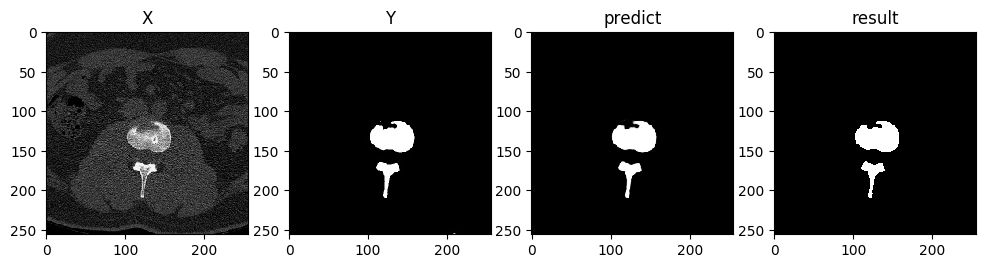

(1, 256, 256, 1)


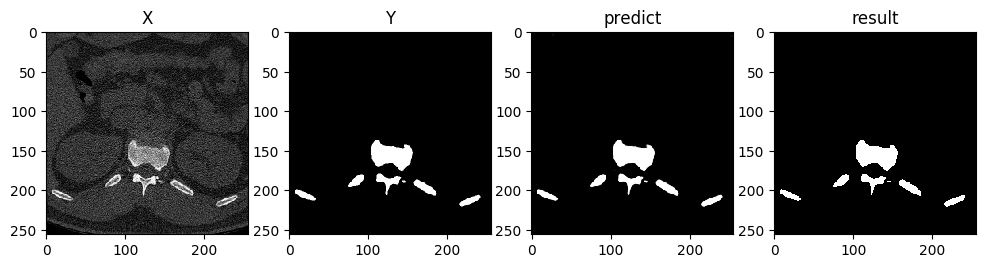

(1, 256, 256, 1)


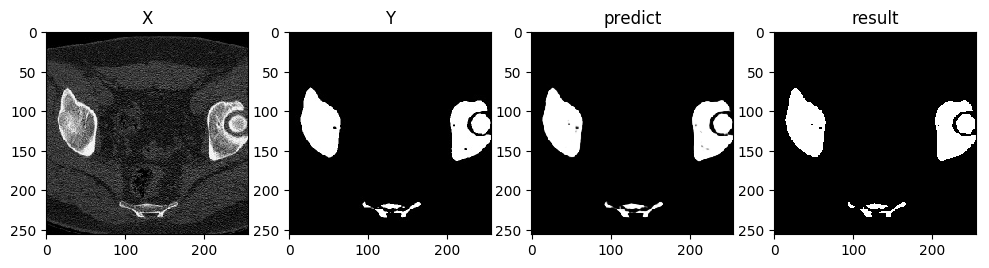

(1, 256, 256, 1)


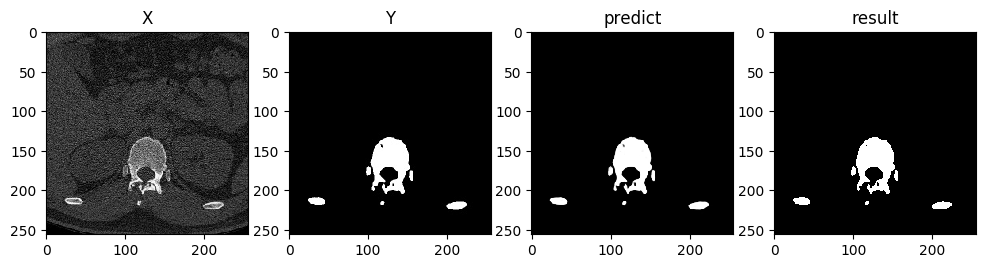

(1, 256, 256, 1)


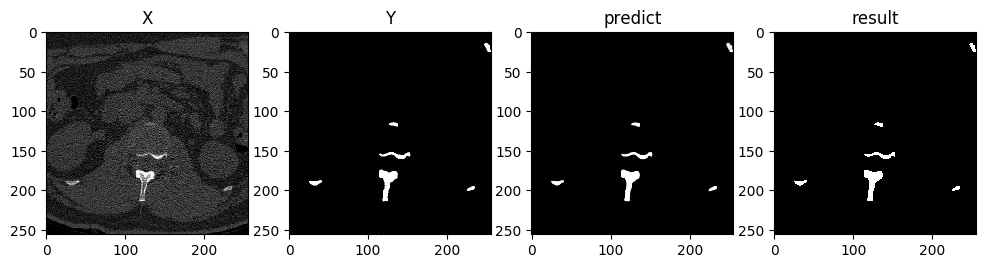

(1, 256, 256, 1)


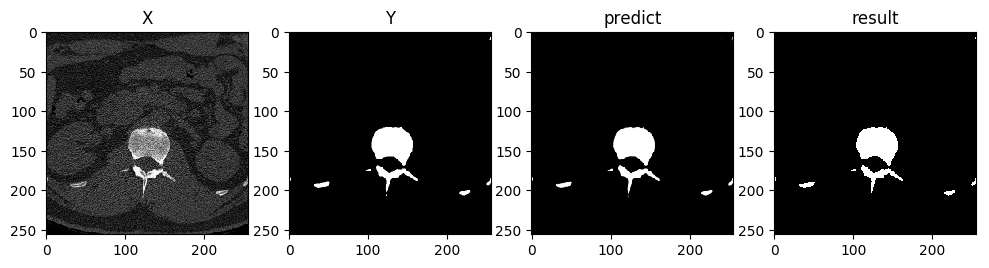

(1, 256, 256, 1)


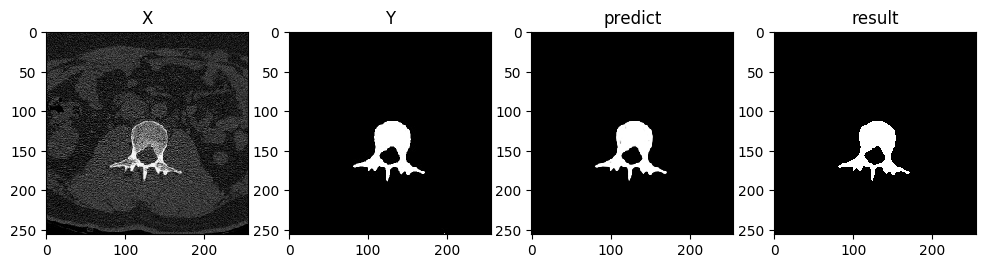

(1, 256, 256, 1)


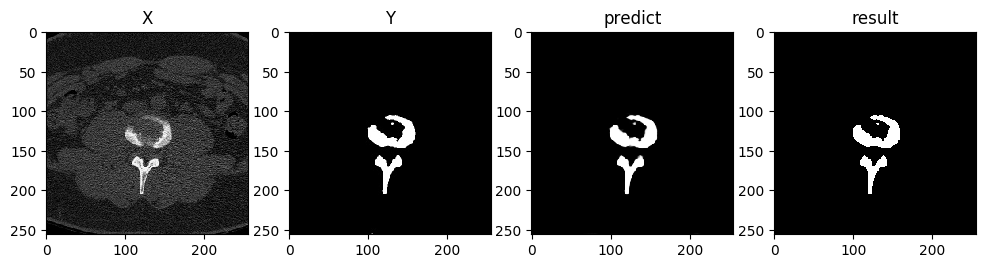

(1, 256, 256, 1)


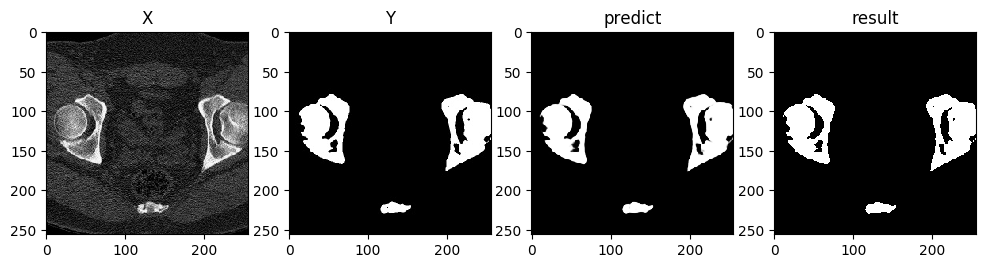

(1, 256, 256, 1)


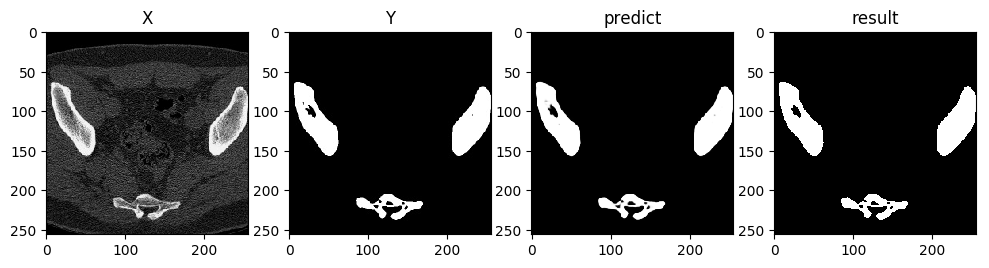

(1, 256, 256, 1)


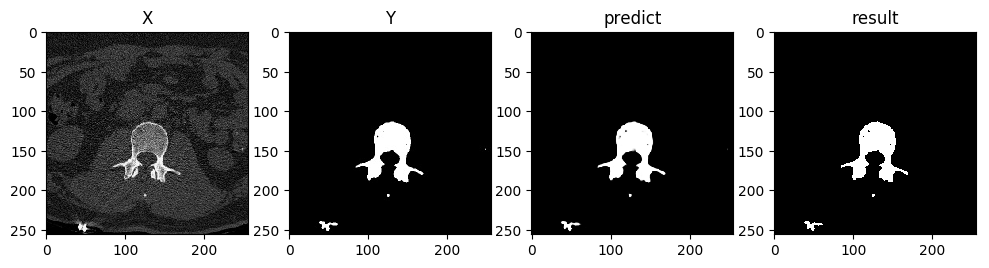

(1, 256, 256, 1)


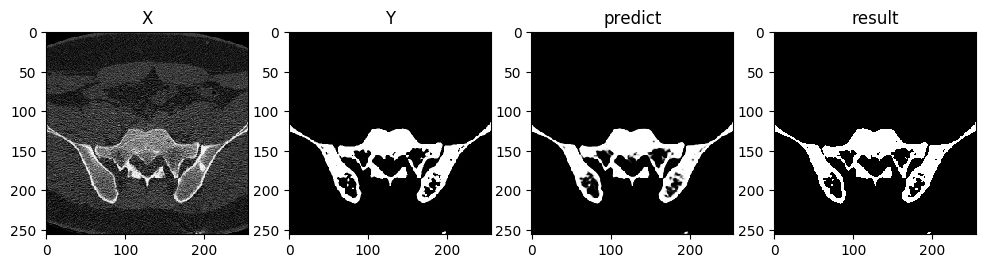

(1, 256, 256, 1)


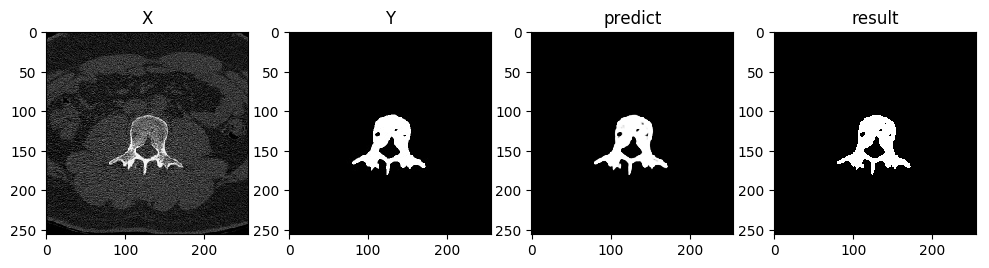

(1, 256, 256, 1)


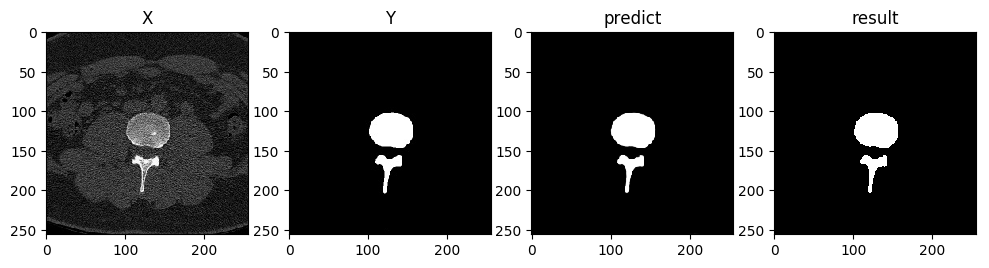

(1, 256, 256, 1)


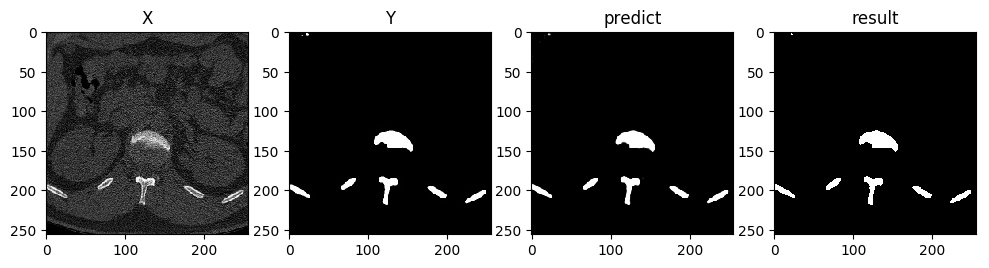

(1, 256, 256, 1)


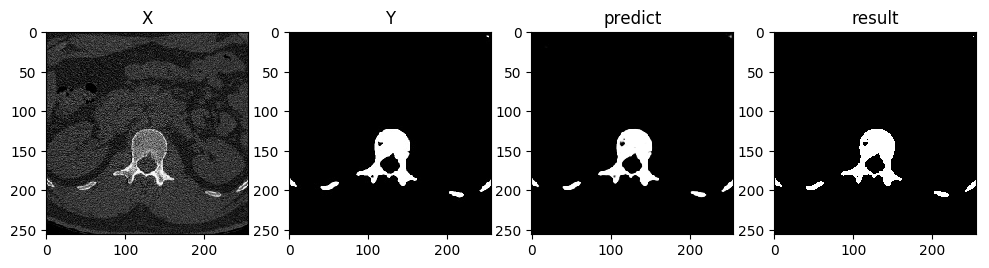

(1, 256, 256, 1)


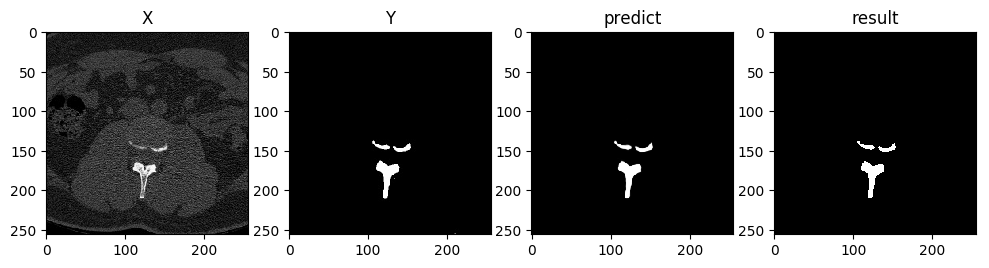

(1, 256, 256, 1)


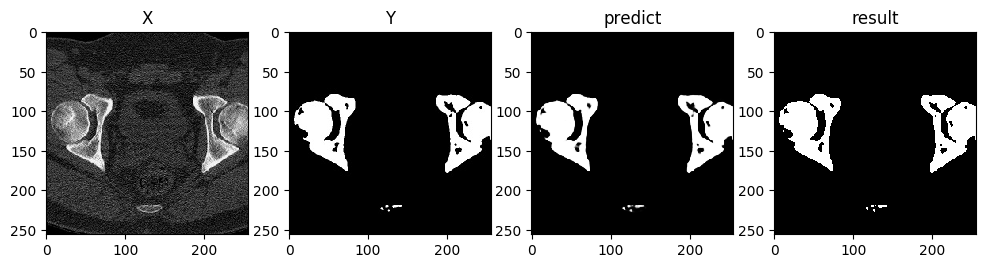

(1, 256, 256, 1)


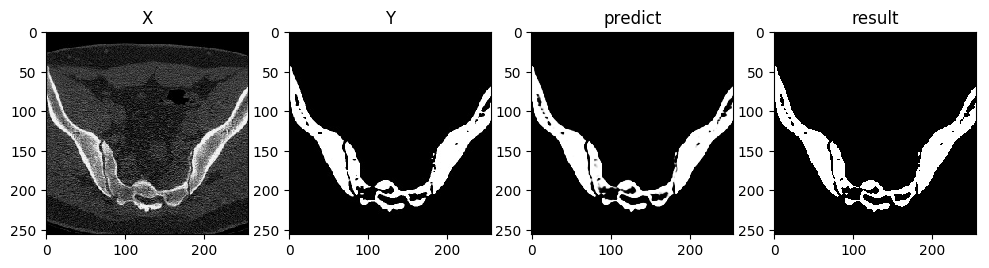

(1, 256, 256, 1)


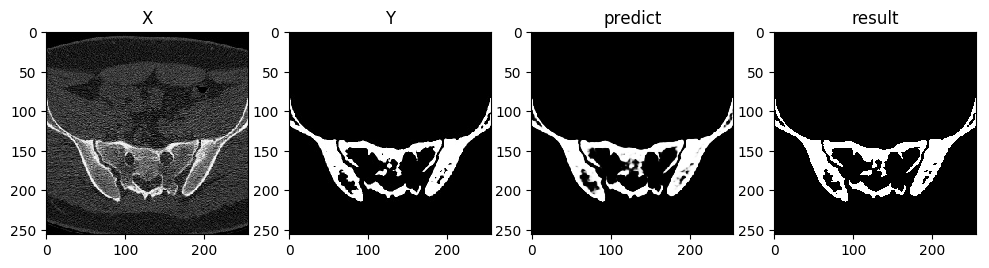

(1, 256, 256, 1)


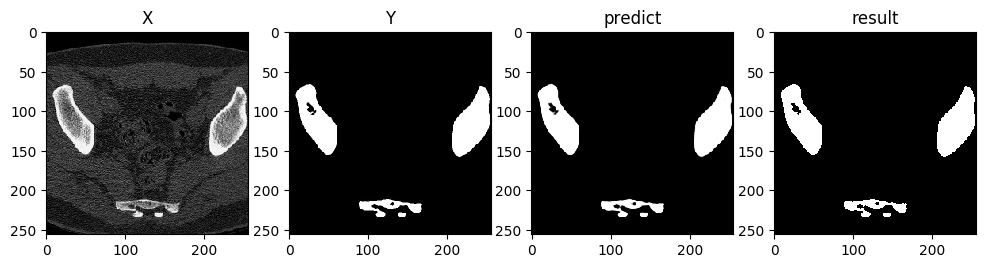

(1, 256, 256, 1)


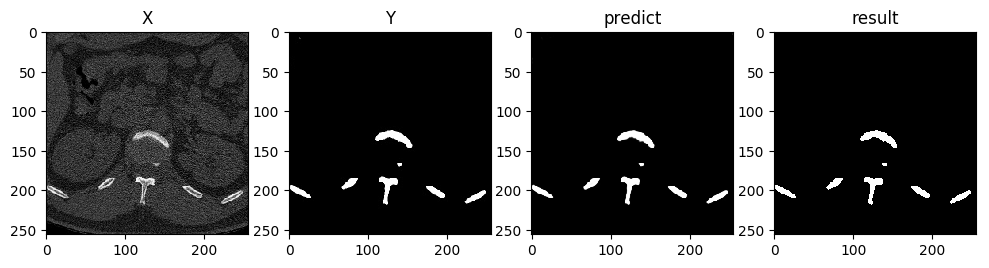

(1, 256, 256, 1)


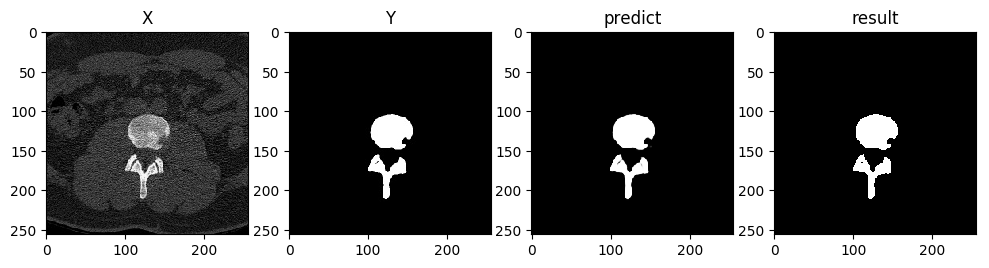

(1, 256, 256, 1)


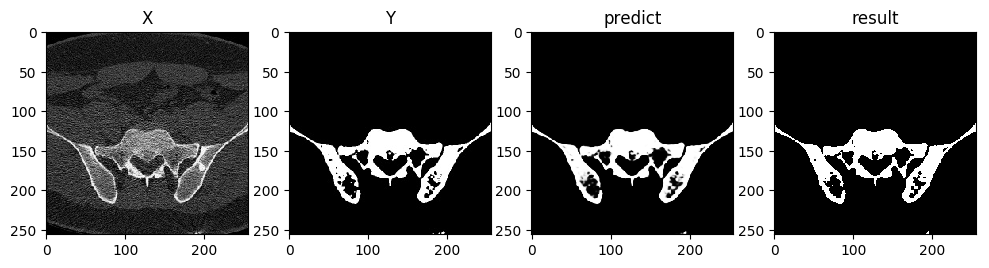

(1, 256, 256, 1)


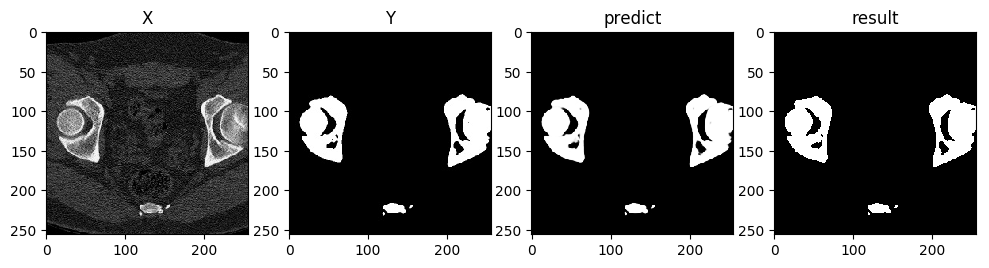

(1, 256, 256, 1)


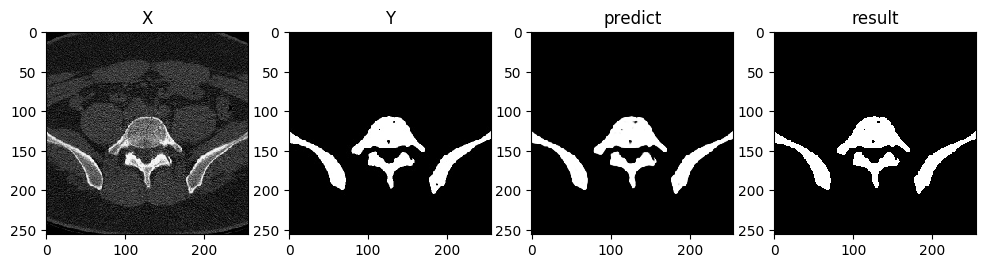

(1, 256, 256, 1)


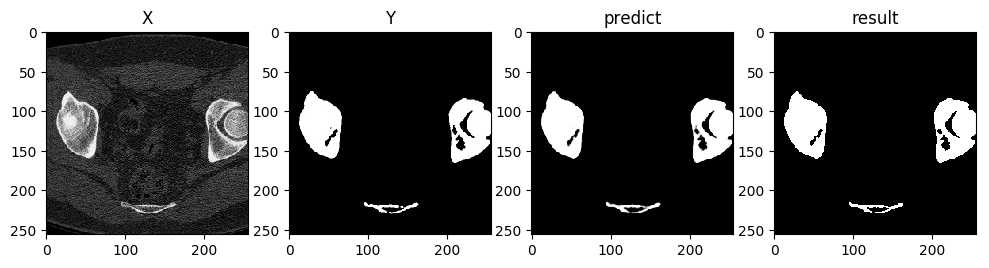

(1, 256, 256, 1)


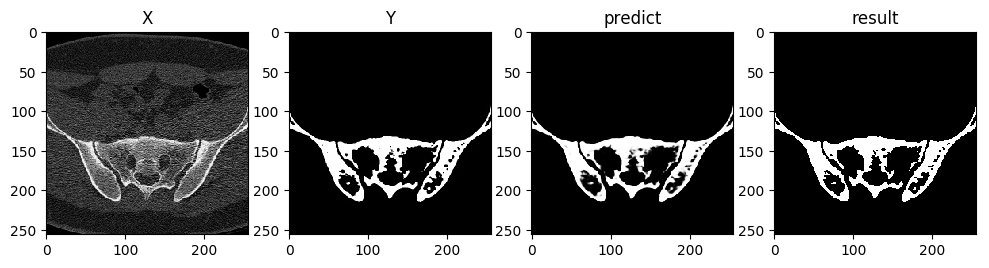

(1, 256, 256, 1)


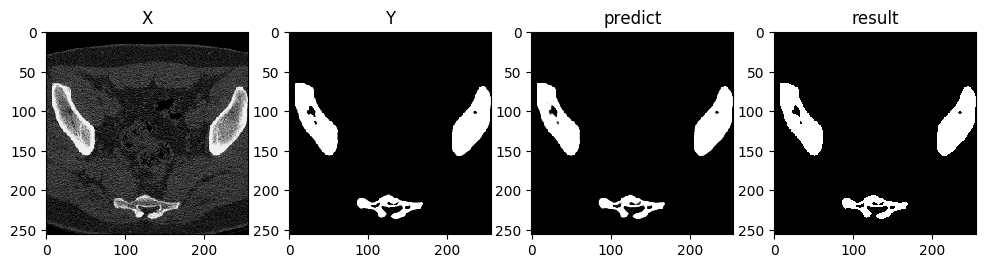

(1, 256, 256, 1)


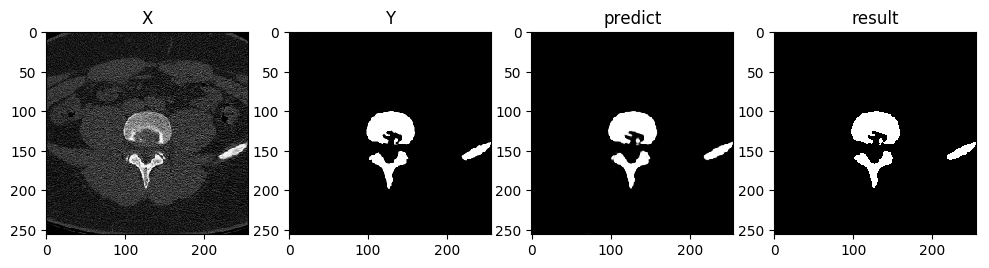

(1, 256, 256, 1)


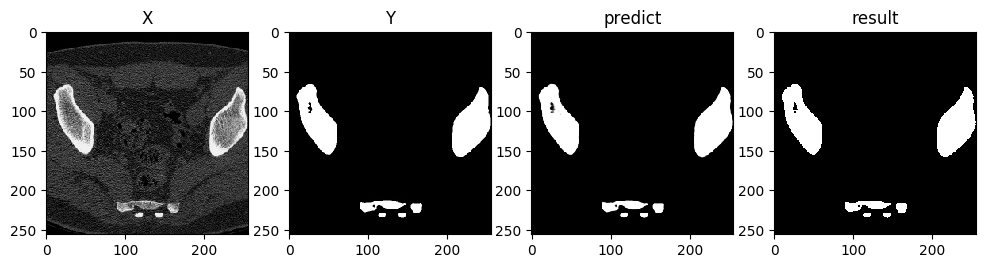

In [9]:
#num = 3
for num in range(0, 31):

    X = X_train[num:num+1]
    Y = Y_train[num:num+1]

    img = model.predict(X)
    img2 = img > 0.5
    print(img.shape)


    plt.figure(num=None, figsize=(12, 15), dpi=100, facecolor='w', edgecolor='k')

    plt.subplot(141), plt.title('X'), plt.imshow(X.reshape(size,size), cmap='gray')

    plt.subplot(142), plt.title('Y'), plt.imshow(Y.reshape(size,size), cmap='gray')

    plt.subplot(143), plt.title('predict'), plt.imshow(img.reshape(size,size), cmap='gray')

    plt.subplot(144), plt.title('result'), plt.imshow(img2.reshape(size,size), cmap='gray')

    plt.show()